In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg as la
from scipy import fft 
from scipy import linalg as la
from scipy import signal
%matplotlib notebook

In [2]:
# what are we doing? we are trying to get the heart rate (HR) and resipiratory rate (RR)
# how are we going to do this?
# using two techniques, SCG and BCG, that need
# info about the mechanical properties of the human body such as acceleration, angular velocity

# first things first, we load the center_sternum dataset and add a time column as index

df=pd.read_csv("center_sternum.txt",sep=None,engine='python')
df['time_s'] = np.arange(0,df.shape[0])/200 # let's construct the time axis, with each sampling separated by a 200th of a second (because sampling rate is 200 Hz)
df=df.set_index('time_s')
df

Log Mode  Log Freq   Timestamp     AccX     AccY    AccZ      GyroX  \
time_s                                                                        
0.000          5       200  1576222772  947.086  435.662  70.638  -6.824428   
0.005          5       200  1576222772  969.168  387.777  88.877   6.183206   
0.010          5       200  1576222772  989.603  380.335  78.751  11.709920   
0.015          5       200  1576222772  954.894  418.033  88.328  17.877860   
0.020          5       200  1576222772  972.096  427.732  99.857  25.221370   
...          ...       ...         ...      ...      ...     ...        ...   
82.505         5       200  1576222847  958.493  291.092 -54.290   1.664122   
82.510         5       200  1576222847  954.650  288.042 -49.654   1.480916   
82.515         5       200  1576222847  967.338  290.482 -63.867   1.114504   
82.520         5       200  1576222847  965.630  300.852 -56.242   0.702290   
82.525         5       200  1576222847  959.957  298.473 -55.998   0.290076   

            GyroY     GyroZ  MagnX  MagnY  MagnZ        qw        qi  \
time_s                                                                 
0.000  -14.244280  1.404580   -454   -490   -178  0.792622  0.254952   
0.005  -12.290080 -7.969466   -454   -490   -177  0.736461  0.275124   
0.010   -4.961832 -7.450382   -454   -490   -177  0.729465  0.275246   
0.015    2.519084 -5.984733   -454   -492   -176  0.723413  0.277200   
0.020    5.404580  4.015267   -454   -492   -176  0.721948  0.280007   
...           ...       ...    ...    ...    ...       ...       ...   
82.505   2.305344 -0.671756   -494   -449   -126  0.650810  0.379162   
82.510   2.488550 -0.702290   -494   -450   -125  0.650239  0.379803   
82.515   3.374046 -0.900763   -494   -450   -125  0.649365  0.380627   
82.520   3.664122 -1.587786   -495   -448   -124  0.648973  0.381329   
82.525   4.061069 -1.343511   -495   -448   -124  0.648462  0.382336   

              qj        qk  
time_s                      
0.000  -0.553850 -0.000031  
0.005  -0.617969  0.006806  
0.010  -0.626118  0.009827  
0.015  -0.632221  0.011383  
0.020  -0.632679  0.010193  
...          ...       ...  
82.505 -0.636402  0.166356  
82.510 -0.636708  0.165960  
82.515 -0.637227  0.165502  
82.520 -0.637348  0.164953  
82.525 -0.637471  0.164159  

[16506 rows x 16 columns]

In [3]:
#drop some columns 

new_df=df.drop(columns=['Log Mode','Log Freq','Timestamp','MagnX','MagnY','MagnZ','qw','qi','qj','qk'])
new_df

AccX     AccY    AccZ      GyroX      GyroY     GyroZ
time_s                                                          
0.000   947.086  435.662  70.638  -6.824428 -14.244280  1.404580
0.005   969.168  387.777  88.877   6.183206 -12.290080 -7.969466
0.010   989.603  380.335  78.751  11.709920  -4.961832 -7.450382
0.015   954.894  418.033  88.328  17.877860   2.519084 -5.984733
0.020   972.096  427.732  99.857  25.221370   5.404580  4.015267
...         ...      ...     ...        ...        ...       ...
82.505  958.493  291.092 -54.290   1.664122   2.305344 -0.671756
82.510  954.650  288.042 -49.654   1.480916   2.488550 -0.702290
82.515  967.338  290.482 -63.867   1.114504   3.374046 -0.900763
82.520  965.630  300.852 -56.242   0.702290   3.664122 -1.587786
82.525  959.957  298.473 -55.998   0.290076   4.061069 -1.343511

[16506 rows x 6 columns]

<IPython.core.display.Javascript object>


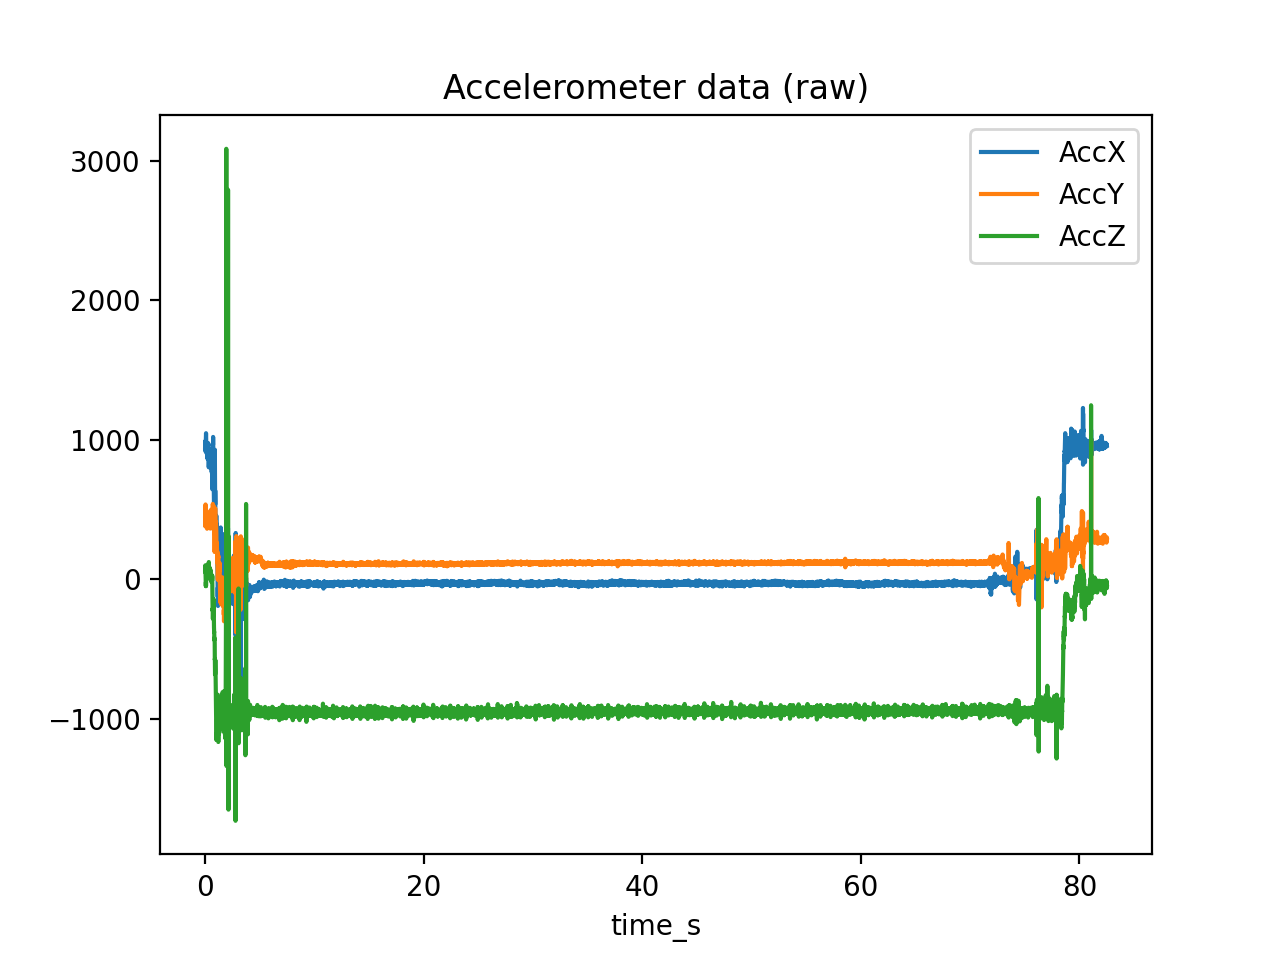

<IPython.core.display.Javascript object>


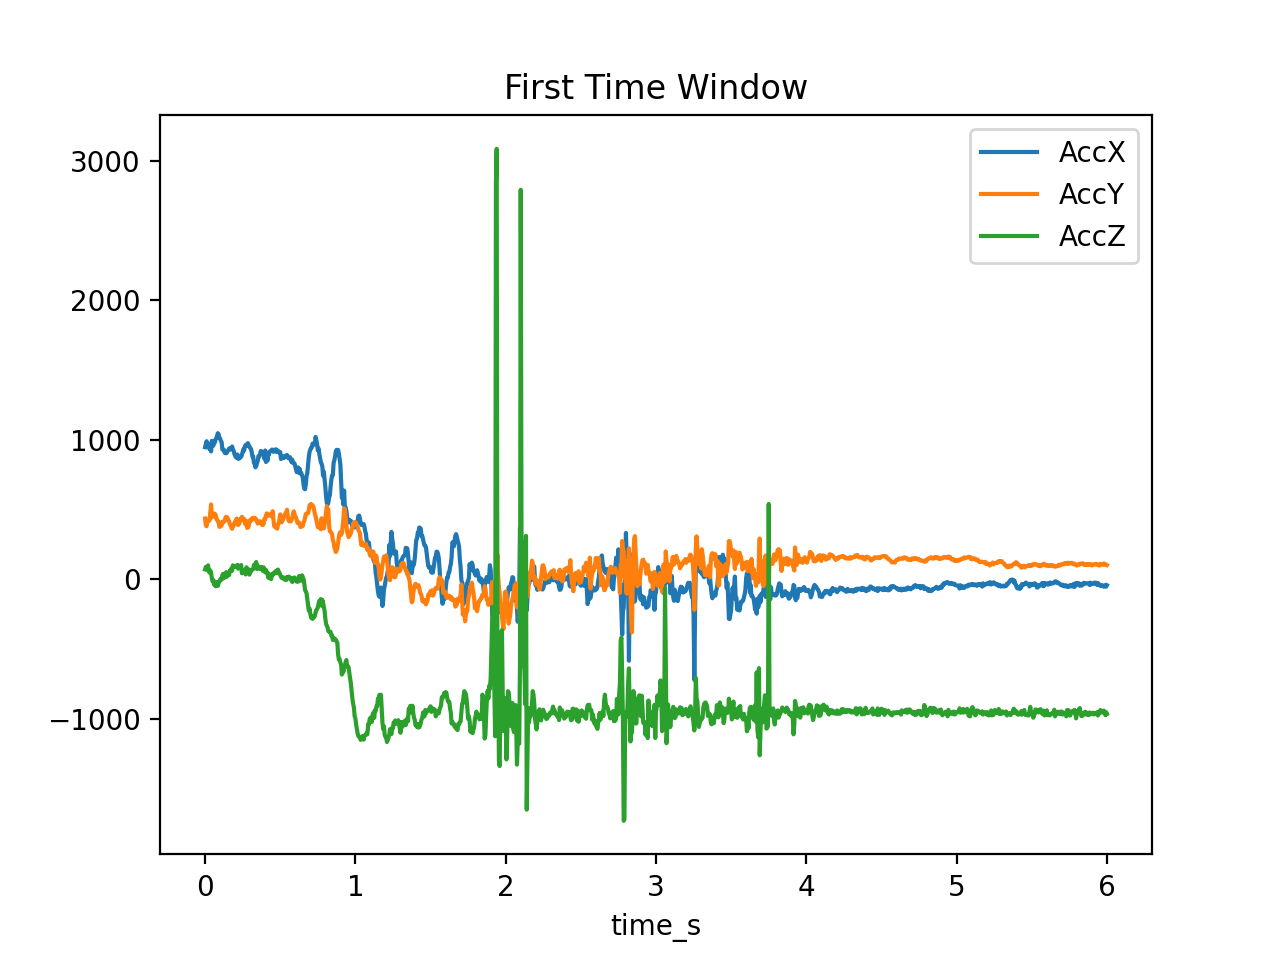

<IPython.core.display.Javascript object>


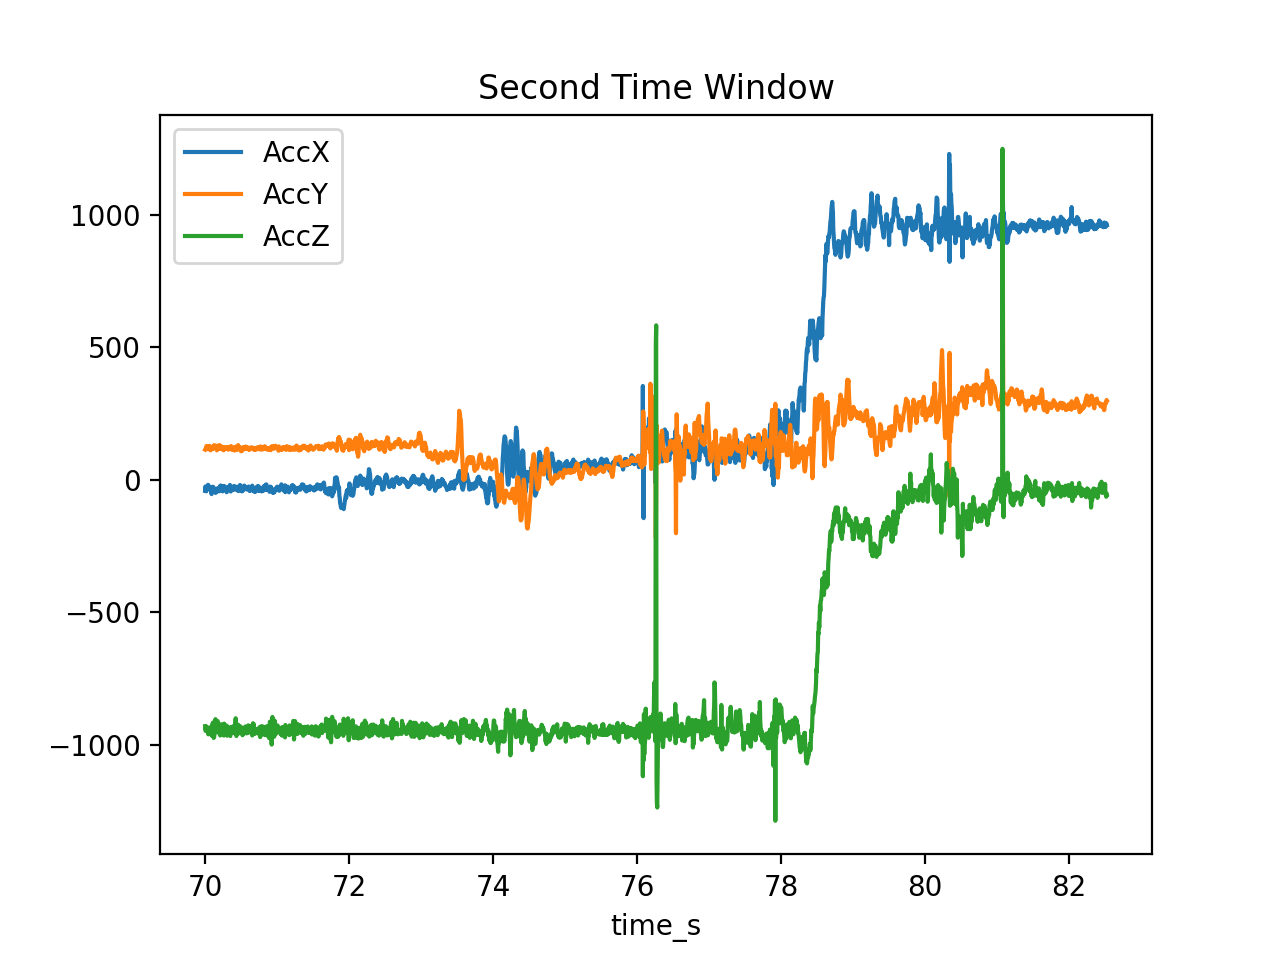

<AxesSubplot:title={'center':'Second Time Window'}, xlabel='time_s'>

In [4]:
# now let's look at the acceleration vector by plotting its three components

new_df.plot(y=['AccX','AccY','AccZ'], title= 'Accelerometer data (raw)')
new_df.loc[0:6].plot(y=['AccX','AccY','AccZ'],title='First Time Window')
new_df.loc[70:].plot(y=['AccX','AccY','AccZ'],title='Second Time Window')

In [5]:
#clean up the data (we select a time intervall from 5s to 71s)

data=new_df.loc[5:71].copy()

data

AccX     AccY     AccZ     GyroX     GyroY     GyroZ
time_s                                                        
5.000  -44.347  137.311 -952.698  0.671756  4.351145  0.564886
5.005  -45.750  131.821 -954.040  0.885496  4.106870  0.091603
5.010  -45.018  133.895 -951.112  1.450382  4.015267 -0.549618
5.015  -49.166  133.529 -947.208  1.603053  4.061069 -0.595420
5.020  -66.612  139.080 -925.675  1.587786  3.648855 -0.732824
...        ...      ...      ...       ...       ...       ...
70.980 -33.794  123.769 -939.522  0.717557  5.847328 -0.137405
70.985 -32.269  125.538 -953.003  0.488550  4.748092 -0.320611
70.990 -38.369  121.146 -956.297 -0.488550  4.885496 -0.824427
70.995 -28.487  124.562 -951.295 -1.343511  5.129771 -0.885496
71.000 -25.742  120.963 -950.929 -1.587786  5.022901 -0.793893

[13201 rows x 6 columns]

<IPython.core.display.Javascript object>


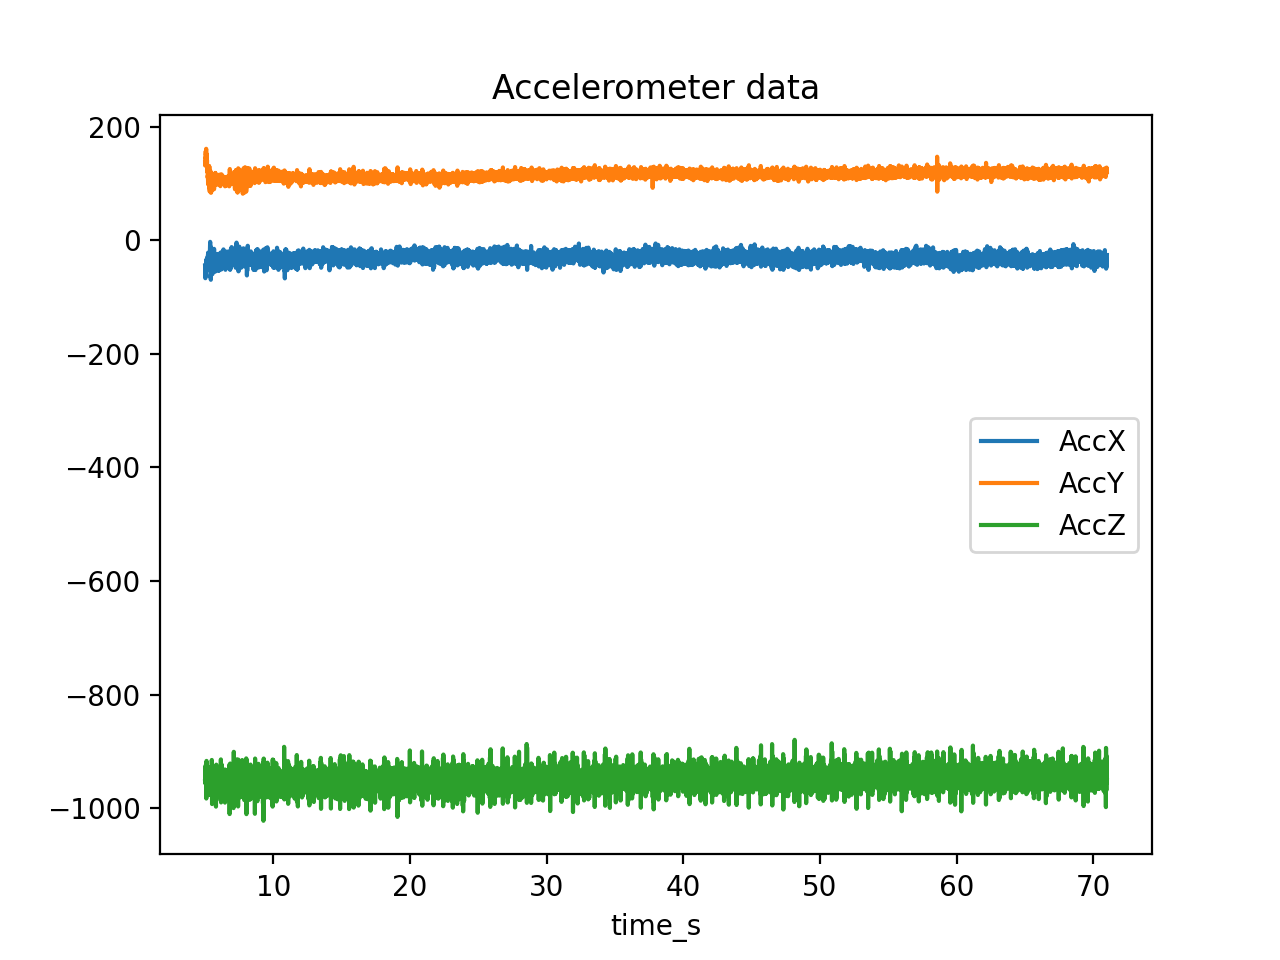

<AxesSubplot:title={'center':'Accelerometer data'}, xlabel='time_s'>

In [6]:
data.plot(y=['AccX','AccY','AccZ'],title= 'Accelerometer data')

<IPython.core.display.Javascript object>


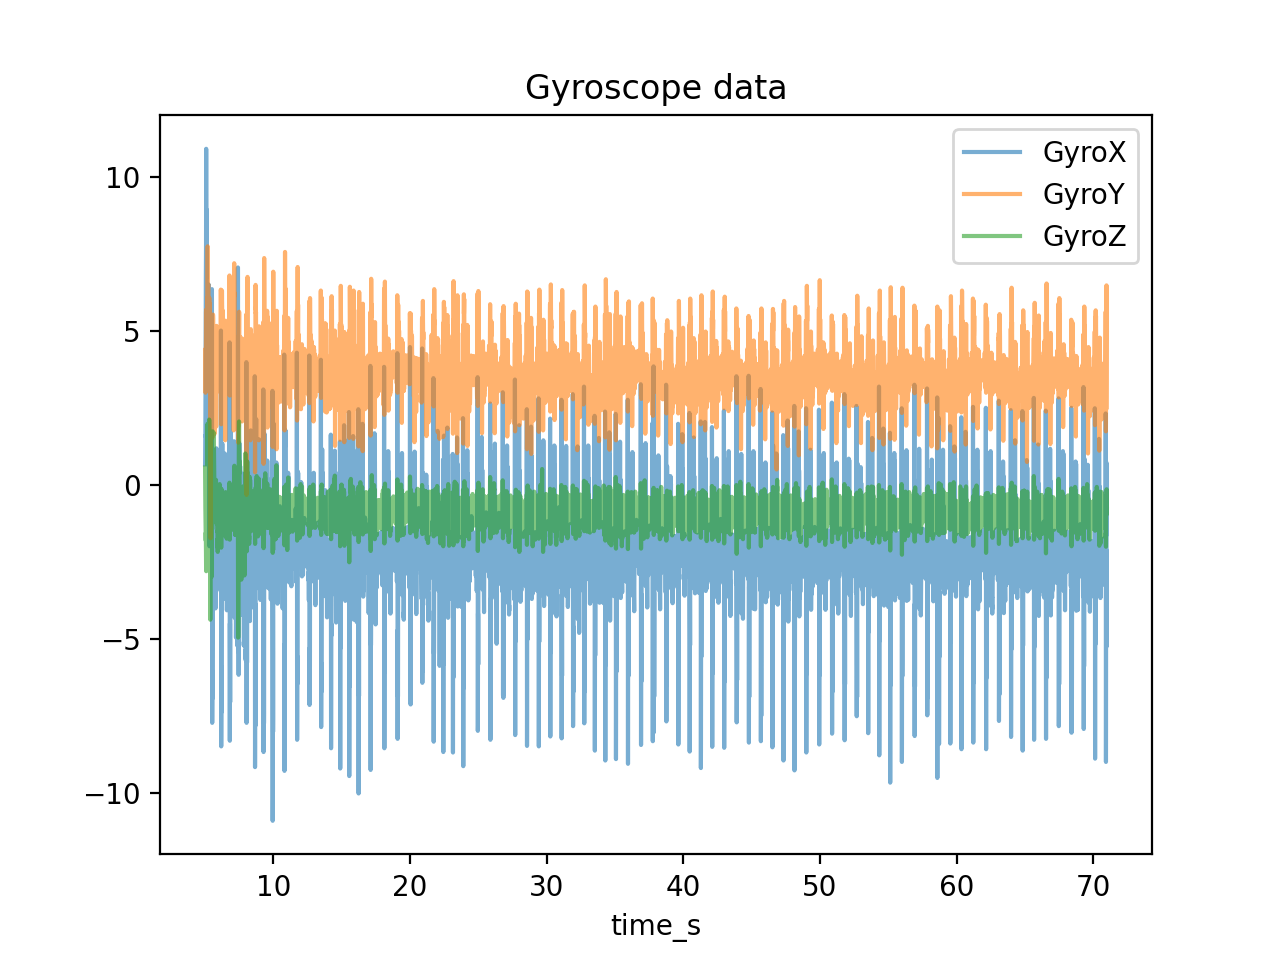

<AxesSubplot:title={'center':'Gyroscope data'}, xlabel='time_s'>

In [7]:
data.plot(y=['GyroX','GyroY','GyroZ'],title= 'Gyroscope data',alpha=0.6)

In [8]:
#normalize dataset

data=(data-data.mean())/data.std()
data

AccX      AccY      AccZ     GyroX     GyroY     GyroZ
time_s                                                            
5.000  -1.847940  3.640941 -0.214197  1.756094  0.868019  3.352149
5.005  -2.041266  2.735764 -0.305753  1.894094  0.544751  2.240789
5.010  -1.940400  3.077719 -0.105994  2.258809  0.423525  0.735077
5.015  -2.511972  3.017374  0.160351  2.357380  0.484139  0.627526
5.020  -4.915932  3.932609  1.629411  2.347523 -0.061377  0.304873
...          ...       ...       ...       ...       ...       ...
70.980 -0.393796  1.408171  0.684718  1.785665  2.848037  1.703035
70.985 -0.183660  1.699839 -0.235005  1.637808  1.393331  1.272831
70.990 -1.024206  0.975697 -0.459734  1.006950  1.575168  0.089771
70.995  0.337478  1.538918 -0.118479  0.454950  1.898437 -0.053630
71.000  0.715724  0.945524 -0.093509  0.297235  1.757007  0.161472

[13201 rows x 6 columns]

In [9]:
data.describe()

AccX          AccY          AccZ         GyroX         GyroY  \
count  1.320100e+04  1.320100e+04  1.320100e+04  1.320100e+04  1.320100e+04   
mean  -1.320788e-15 -7.601113e-15 -2.363243e-13  1.042261e-15  7.261604e-15   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -5.294178e+00 -5.441002e+00 -4.966795e+00 -5.705774e+00 -7.173276e+00   
25%   -6.375546e-01 -5.932765e-01 -6.053917e-01 -4.223373e-01 -5.664825e-01   
50%    9.665543e-03  5.040494e-02 -2.692317e-02 -5.762291e-02 -8.158053e-02   
75%    6.652912e-01  6.337413e-01  5.515454e-01  3.958061e-01  4.437295e-01   
max    3.909798e+00  7.603604e+00  4.763129e+00  8.360385e+00  5.353365e+00   

              GyroZ  
count  1.320100e+04  
mean  -8.198630e-15  
std    1.000000e+00  
min   -9.589811e+00  
25%   -5.913851e-01  
50%    1.807055e-02  
75%    5.916754e-01  
max    7.008878e+00

<IPython.core.display.Javascript object>


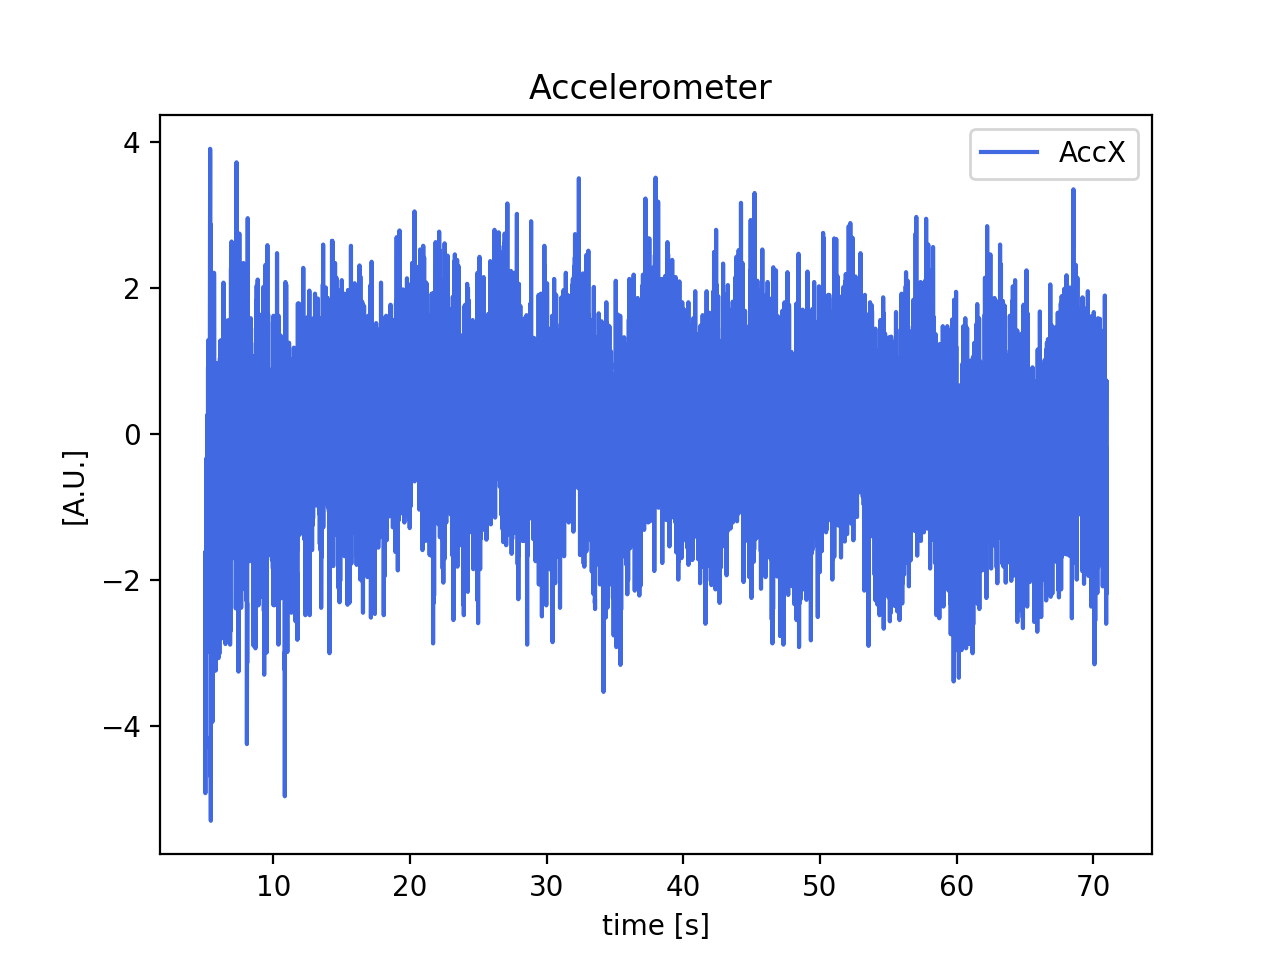

<IPython.core.display.Javascript object>


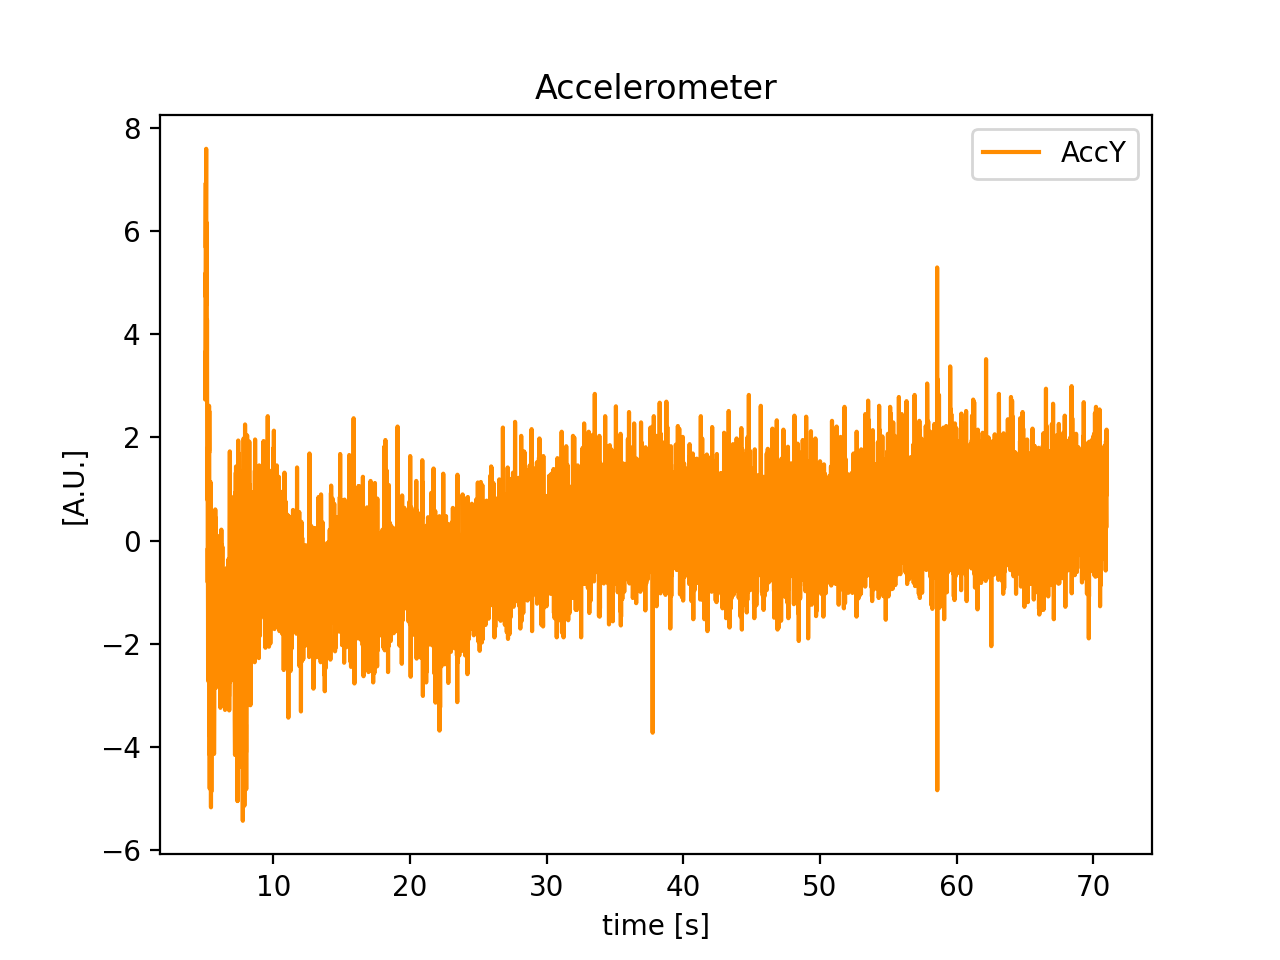

<IPython.core.display.Javascript object>


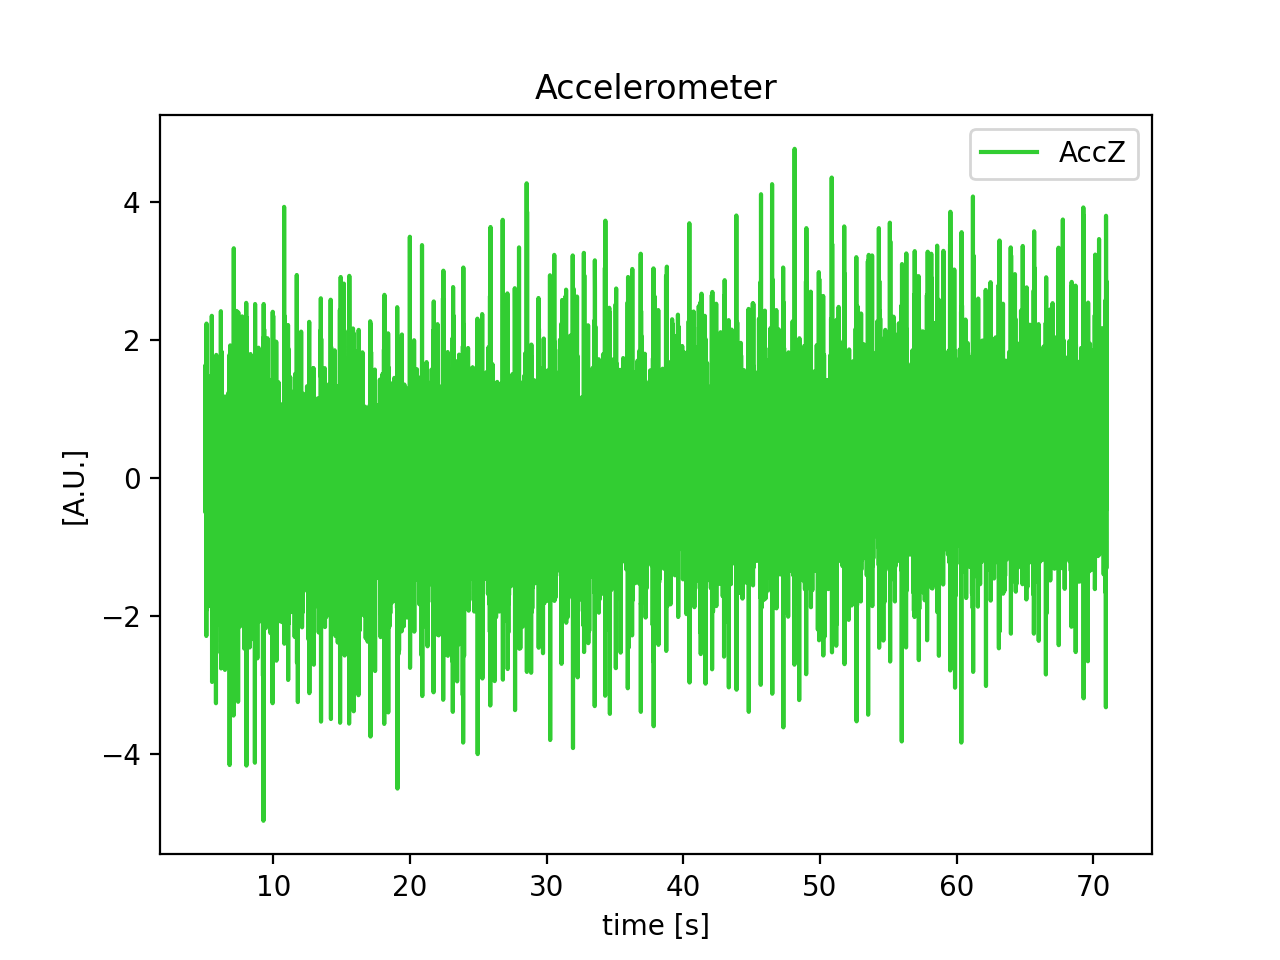

<AxesSubplot:title={'center':'Accelerometer'}, xlabel='time [s]', ylabel='[A.U.]'>

In [10]:
#accelerometer plots

data.plot(y=['AccX'],color='royalblue', title='Accelerometer ',ylabel='[A.U.]', xlabel='time [s]')
data.plot(y=['AccY'],color='darkorange', title='Accelerometer',ylabel='[A.U.]', xlabel='time [s]')
data.plot(y=['AccZ'],color='limegreen', title='Accelerometer',ylabel='[A.U.]', xlabel='time [s]')

<IPython.core.display.Javascript object>


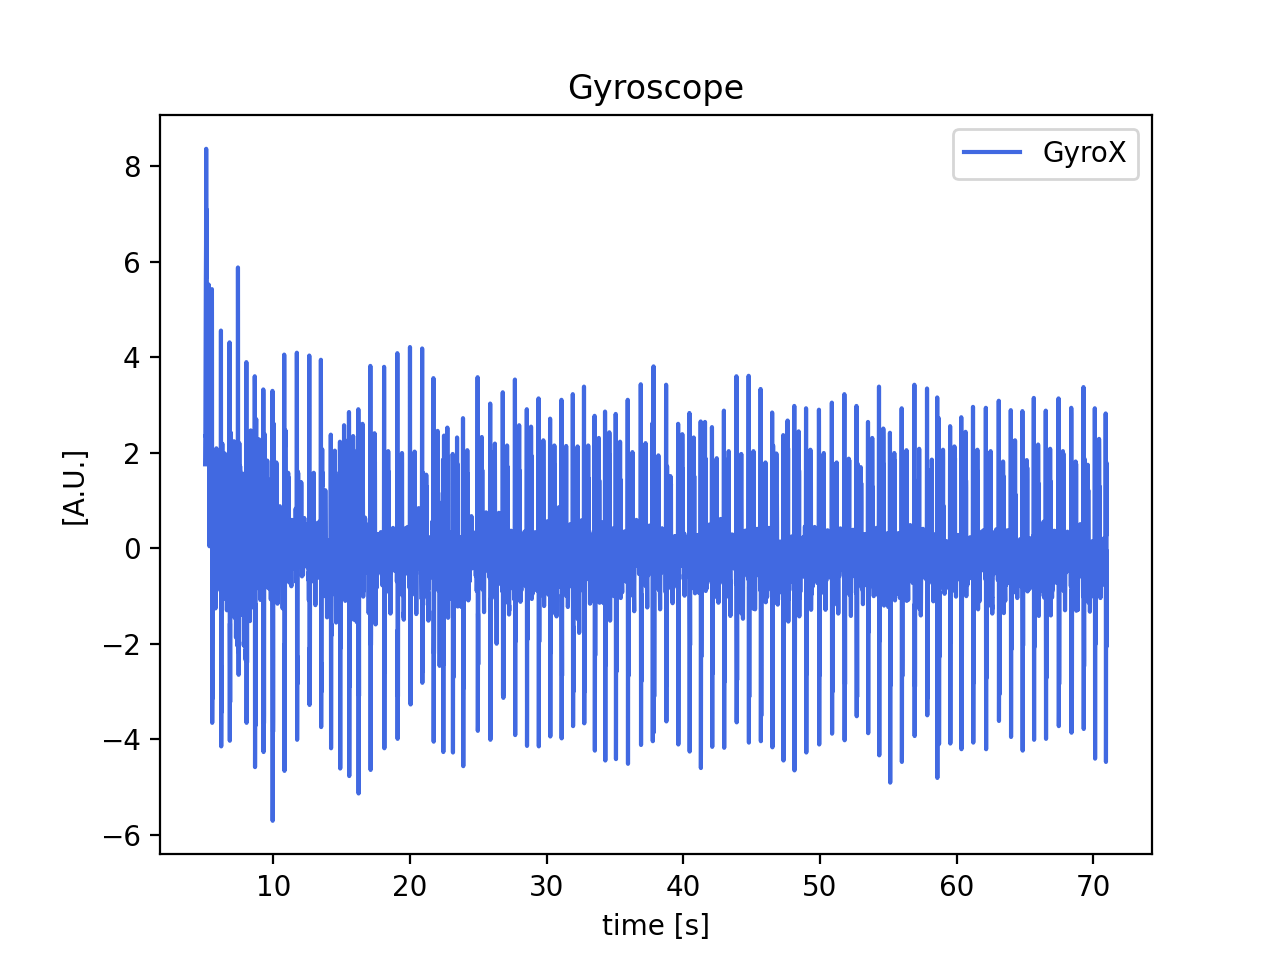

<IPython.core.display.Javascript object>


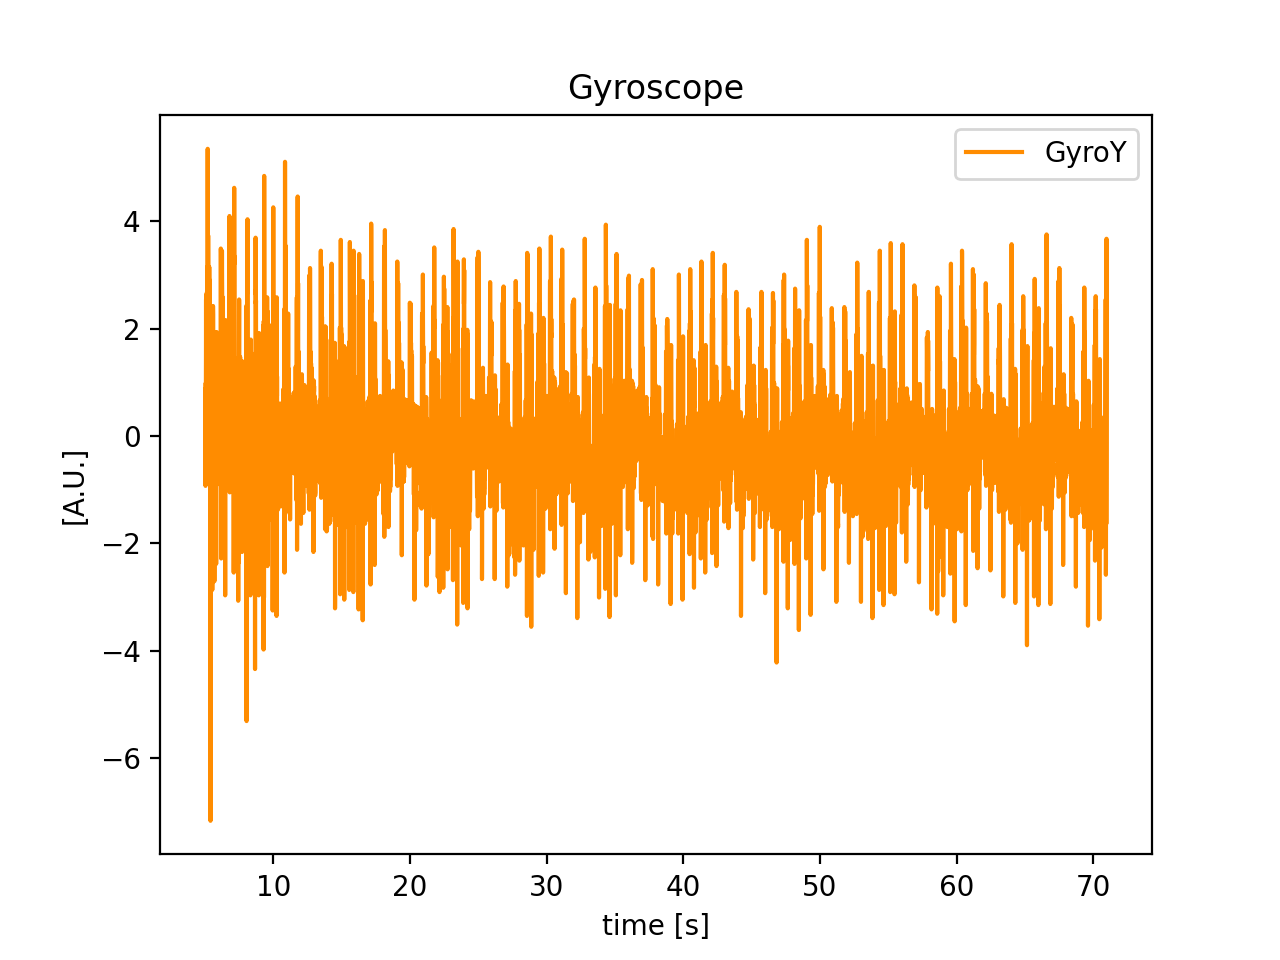

<IPython.core.display.Javascript object>


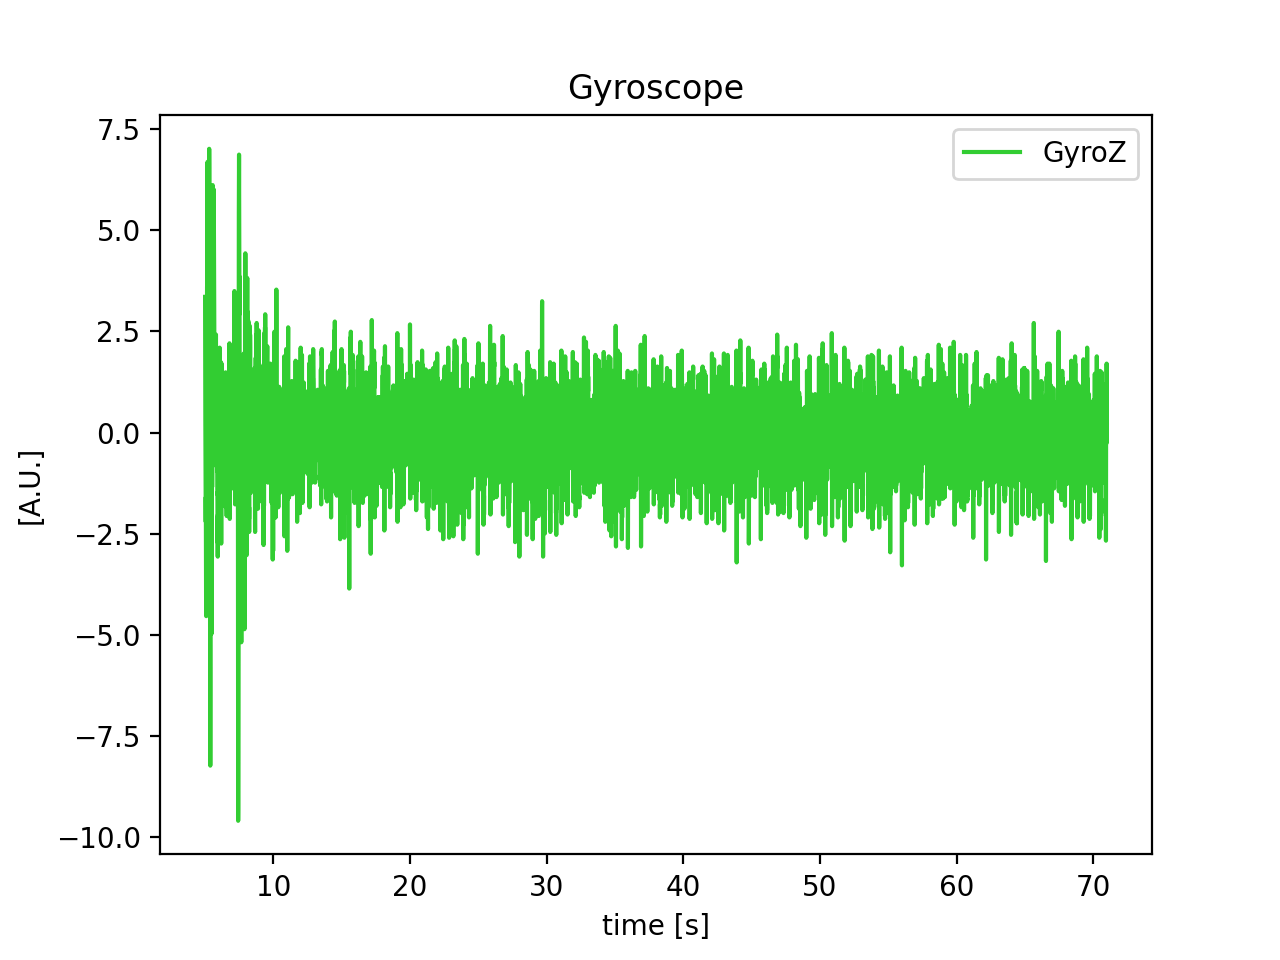

<AxesSubplot:title={'center':'Gyroscope'}, xlabel='time [s]', ylabel='[A.U.]'>

In [11]:
#gyroscope plots

data.plot(y=['GyroX'],color='royalblue', title='Gyroscope',ylabel='[A.U.]', xlabel='time [s]')
data.plot(y=['GyroY'],color='darkorange', title='Gyroscope',ylabel='[A.U.]', xlabel='time [s]')
data.plot(y=['GyroZ'],color='limegreen', title='Gyroscope',ylabel='[A.U.]', xlabel='time [s]')

          AccX      AccY      AccZ
AccX  1.000000 -0.176903 -0.388234
AccY -0.176903  1.000000  0.187383
AccZ -0.388234  0.187383  1.000000 

Contributions to variance along the three eigenvectors' direction:
[0.204 0.291 0.506]


<IPython.core.display.Javascript object>


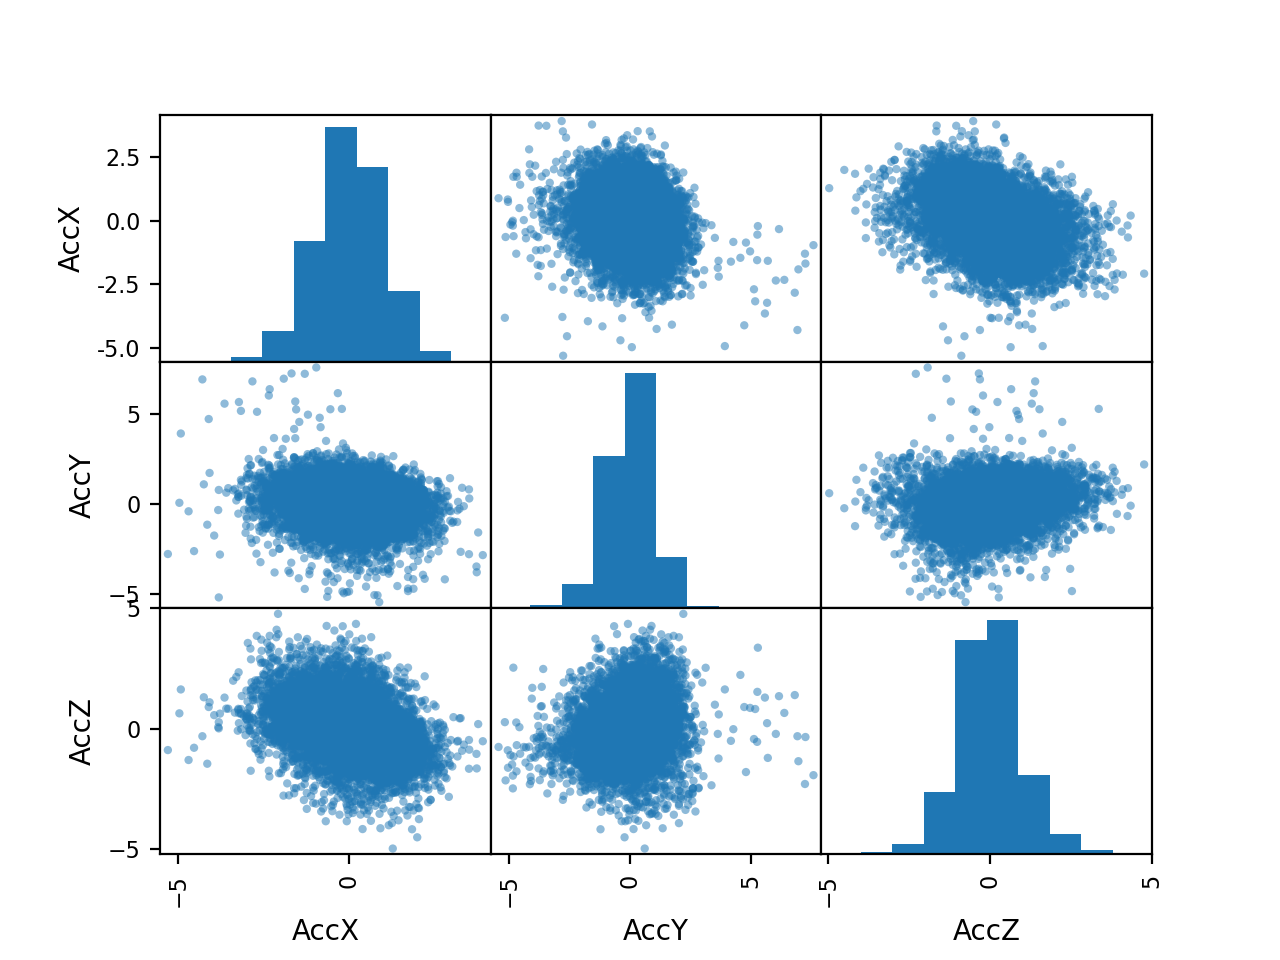

<IPython.core.display.Javascript object>


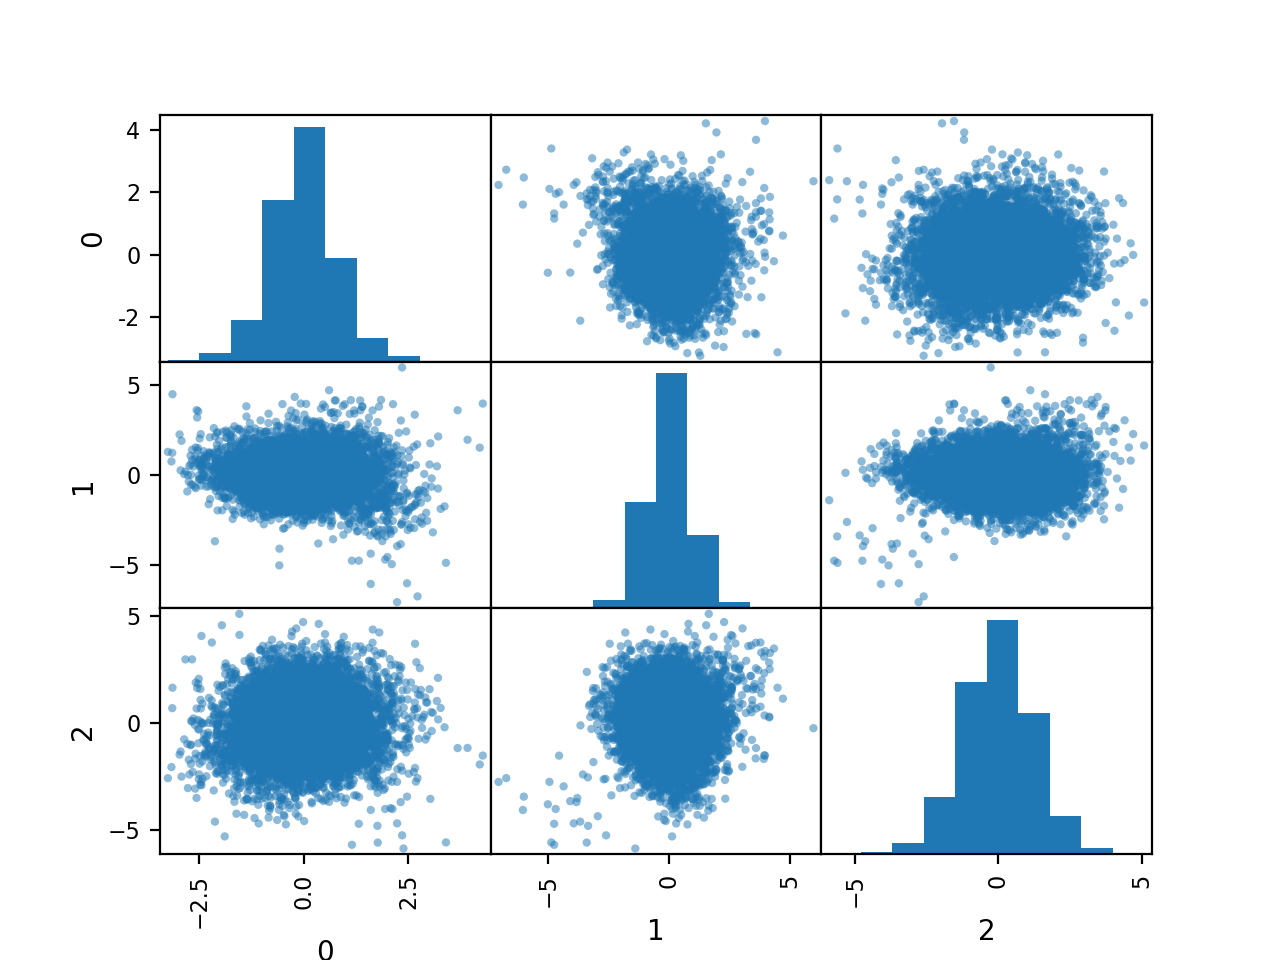

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>]], dtype=object)

In [12]:
#PCA acc

c_acc=data[['AccX','AccY','AccZ']].cov()
print(c_acc,'\n')
l_acc,V_acc=la.eigh(c_acc) #V[:,i] is the normalized eigenvector corresponding to the l[i] eigenvalue 

print("Contributions to variance along the three eigenvectors' direction:")
with np.printoptions(precision=3, suppress=True):
    print(l_acc/c_acc.values.trace()) 
data_acc_transf = (V_acc.T @ data[['AccX','AccY','AccZ']].T).T

pd.plotting.scatter_matrix(data[['AccX','AccY','AccZ']])
pd.plotting.scatter_matrix(data_acc_transf)

          GyroX     GyroY     GyroZ
GyroX  1.000000  0.398644  0.276397
GyroY  0.398644  1.000000  0.408734
GyroZ  0.276397  0.408734  1.000000 

Contributions to variance along the three eigenvectors' direction:
[0.184 0.241 0.575]


<IPython.core.display.Javascript object>


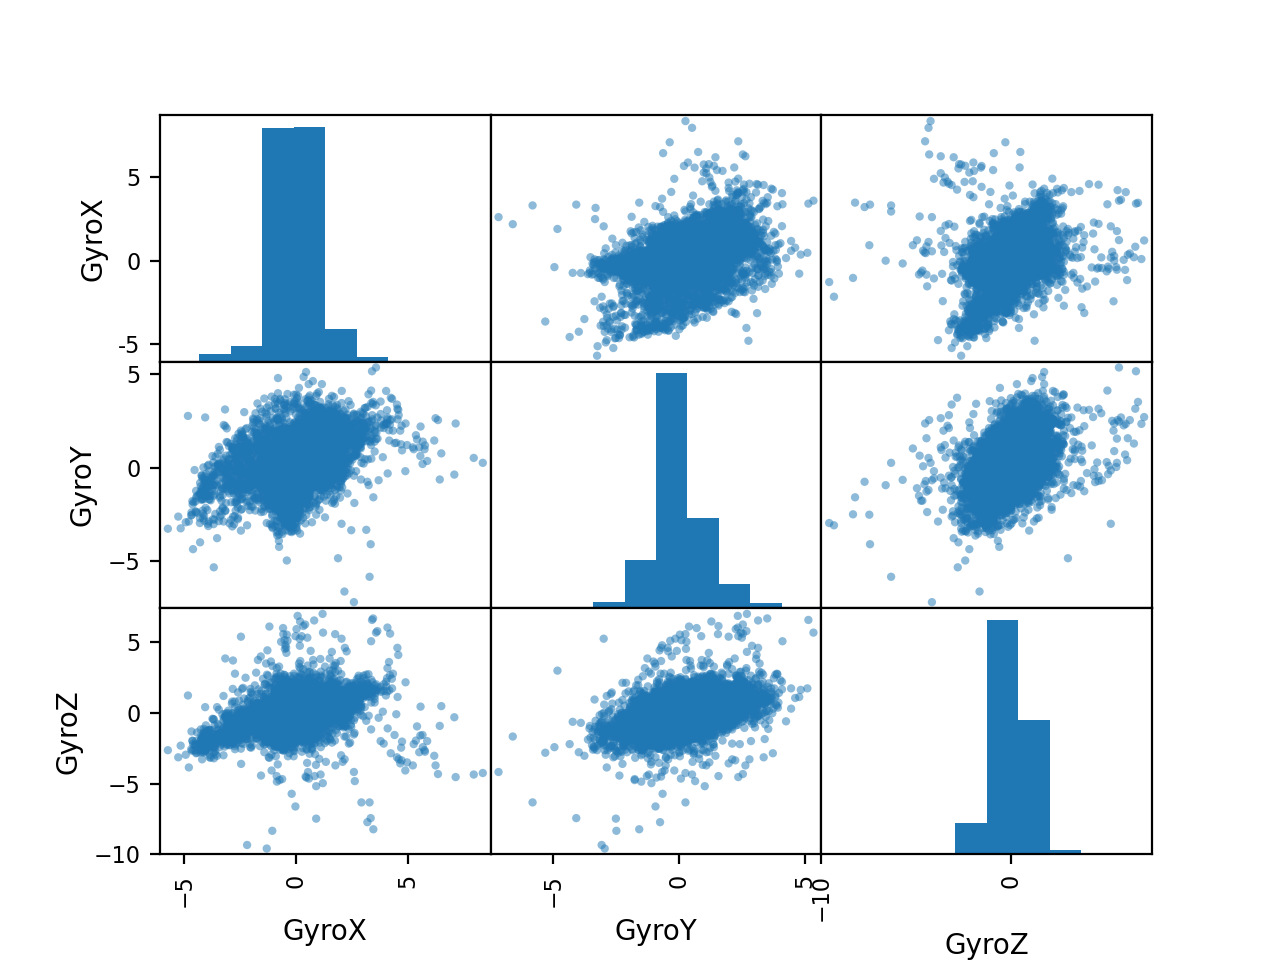

<IPython.core.display.Javascript object>


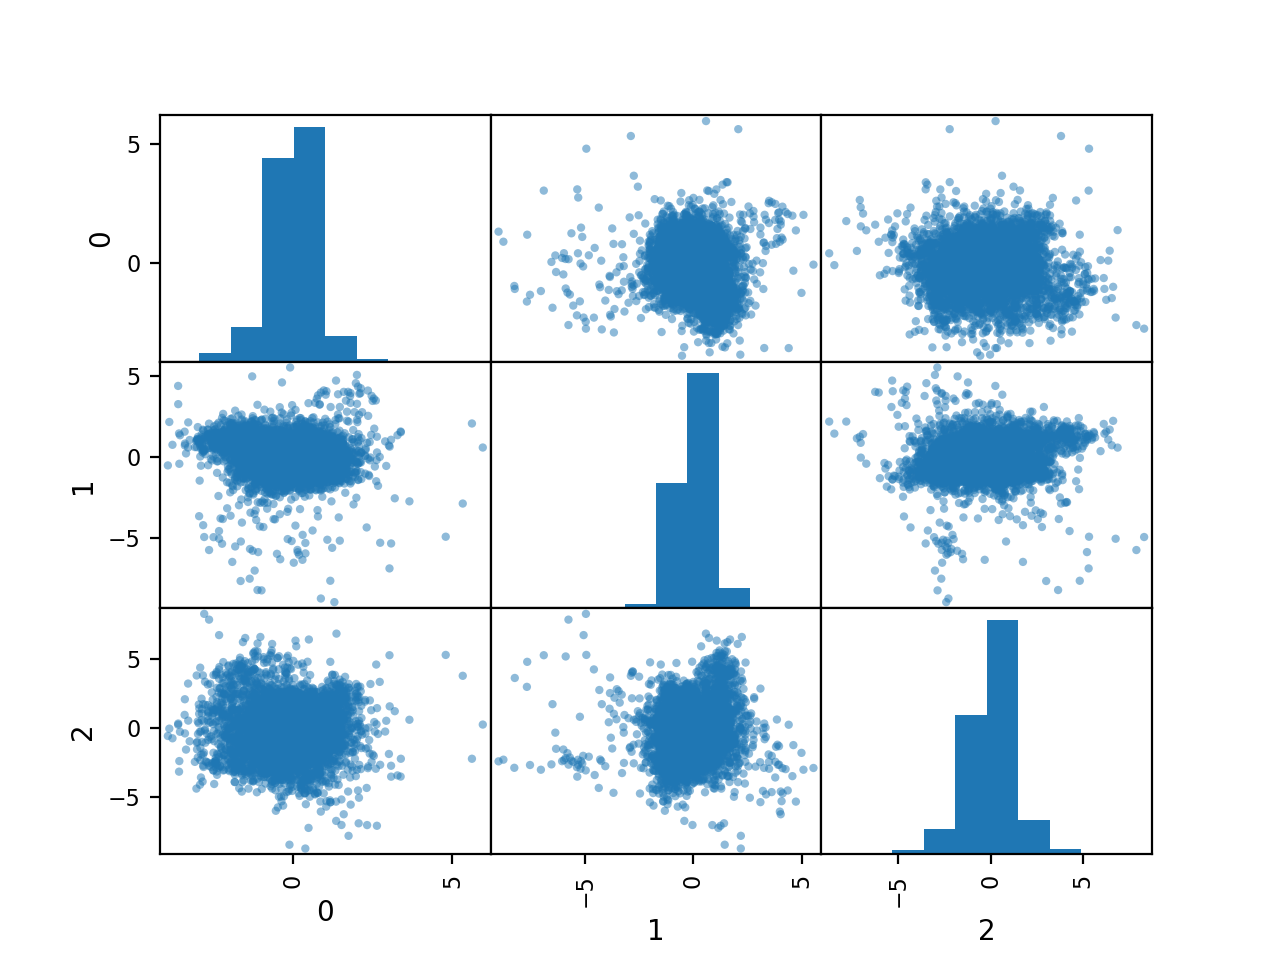

array([[<AxesSubplot:xlabel='0', ylabel='0'>,
        <AxesSubplot:xlabel='1', ylabel='0'>,
        <AxesSubplot:xlabel='2', ylabel='0'>],
       [<AxesSubplot:xlabel='0', ylabel='1'>,
        <AxesSubplot:xlabel='1', ylabel='1'>,
        <AxesSubplot:xlabel='2', ylabel='1'>],
       [<AxesSubplot:xlabel='0', ylabel='2'>,
        <AxesSubplot:xlabel='1', ylabel='2'>,
        <AxesSubplot:xlabel='2', ylabel='2'>]], dtype=object)

In [13]:
#PCA gyro

c_gyro=data[['GyroX','GyroY','GyroZ']].cov()
print(c_gyro,'\n')
l_gyro,V_gyro=la.eigh(c_gyro) #V[:,i] is the normalized eigenvector corresponding to the l[i] eigenvalue 

print("Contributions to variance along the three eigenvectors' direction:")
with np.printoptions(precision=3, suppress=True):
    print(l_gyro/c_gyro.values.trace()) 
data_gyro_transf = (V_gyro.T @ data[['GyroX','GyroY','GyroZ']].T).T

pd.plotting.scatter_matrix(data[['GyroX','GyroY','GyroZ']])
pd.plotting.scatter_matrix(data_gyro_transf)

<IPython.core.display.Javascript object>


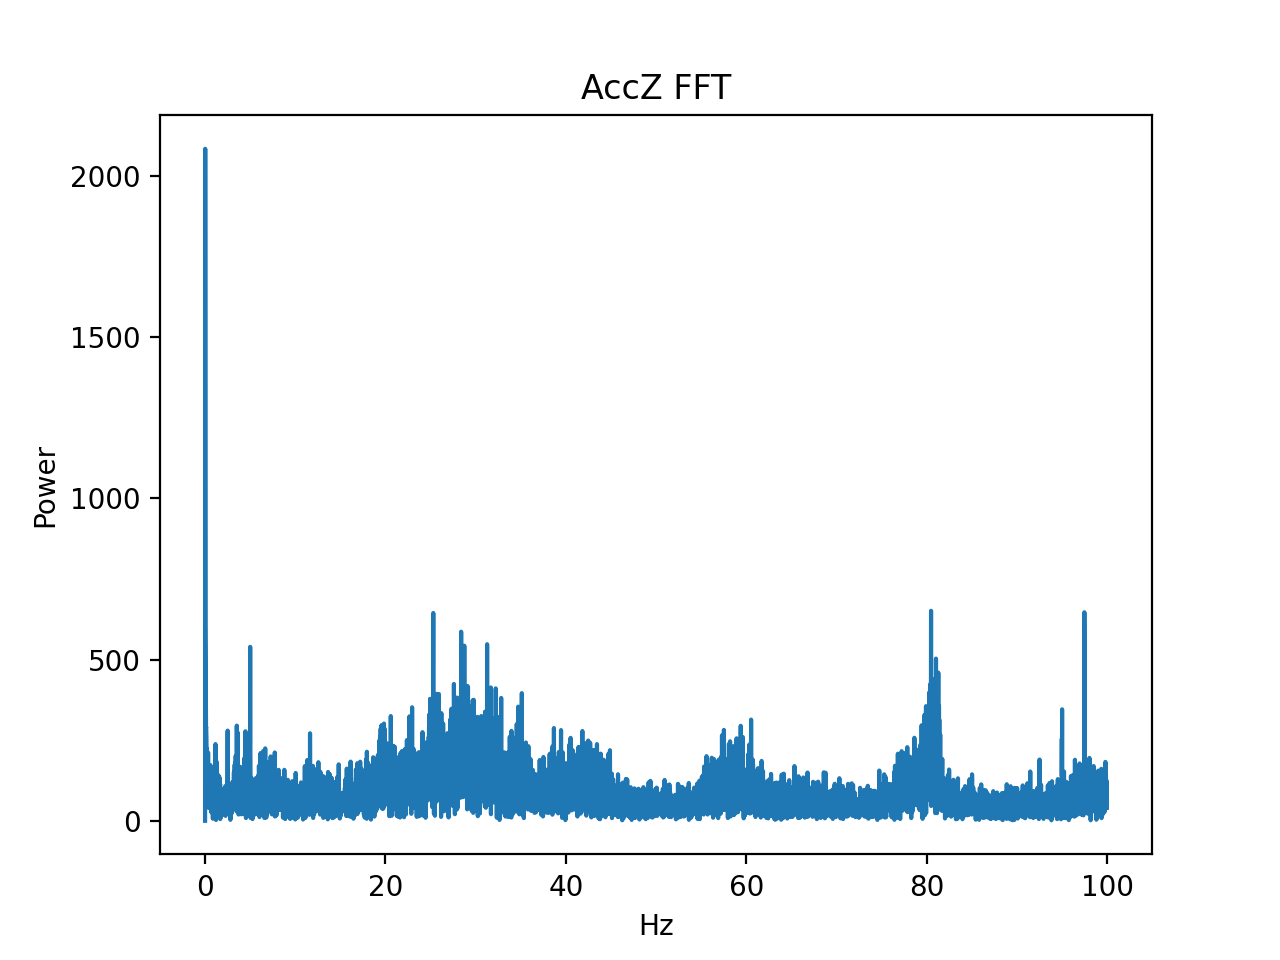

Text(0, 0.5, 'Power')

In [43]:
#fft

time_step=0.005

accZ=data['AccZ'].values

fft_accZ=fft.fft(accZ)
accZ_freq = fft.fftfreq(accZ.size, d=time_step)
power_accZ = np.abs(fft_accZ)

mask=np.where(accZ_freq>=0)

accZ_freq1=accZ_freq[mask]
power_accZ1=power_accZ[mask]

fig, ax = plt.subplots()
ax.plot(accZ_freq1,power_accZ1)
ax.set_title('AccZ FFT')
ax.set_xlabel('Hz')
ax.set_ylabel('Power')


<IPython.core.display.Javascript object>


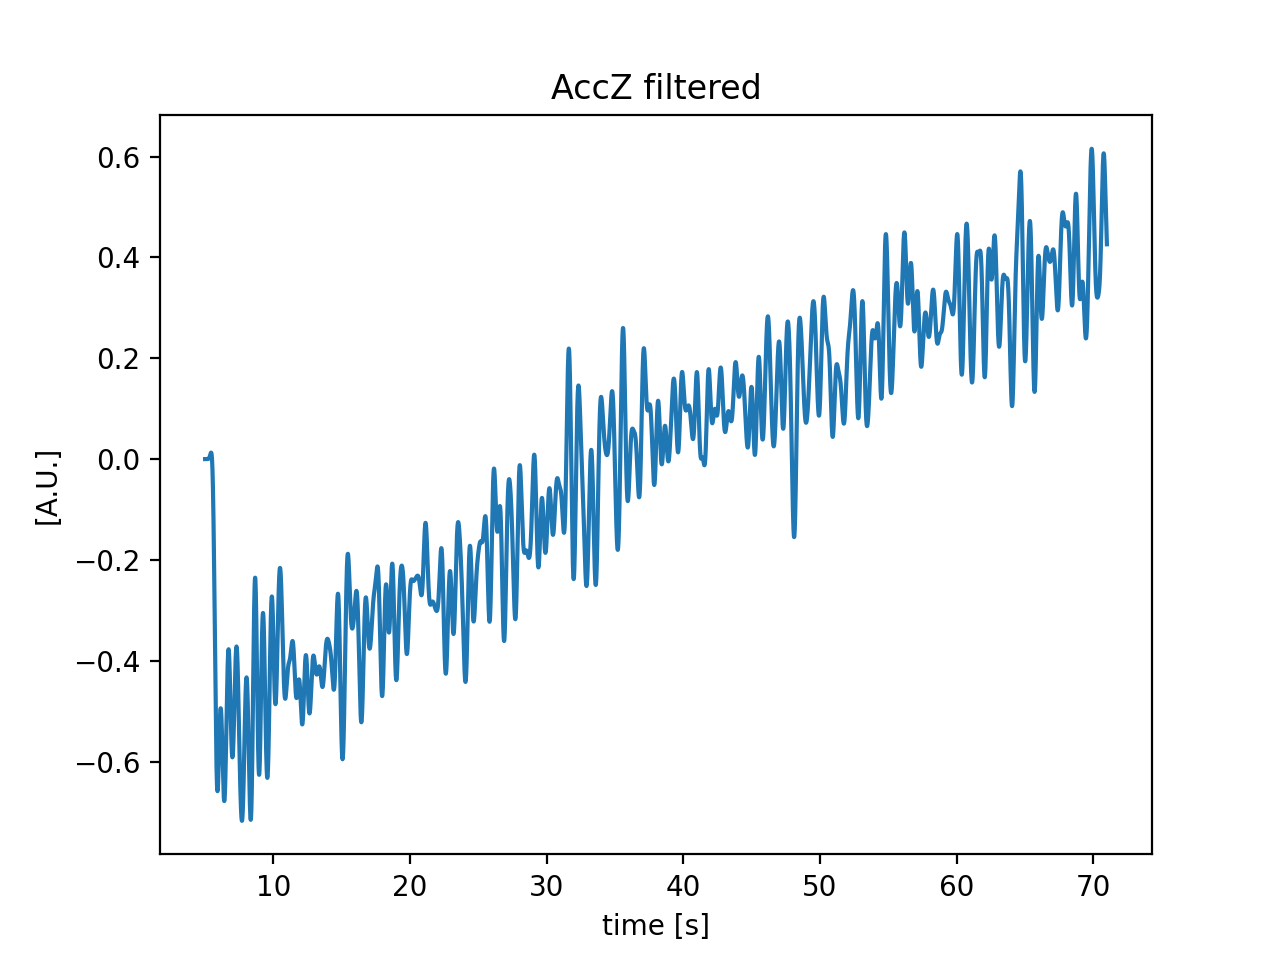

Text(0, 0.5, '[A.U.]')

In [71]:
#butter filter on accZ

t=np.linspace(5, 71, len(accZ))
N=10

sos = signal.butter(N, 2, 'lp', fs=200, output='sos')
filtered = signal.sosfilt(sos, accZ)

fig, ax = plt.subplots()
ax.plot(t,filtered)
ax.set_title('AccZ filtered')
ax.set_xlabel('time [s]')
ax.set_ylabel('[A.U.]')



<IPython.core.display.Javascript object>


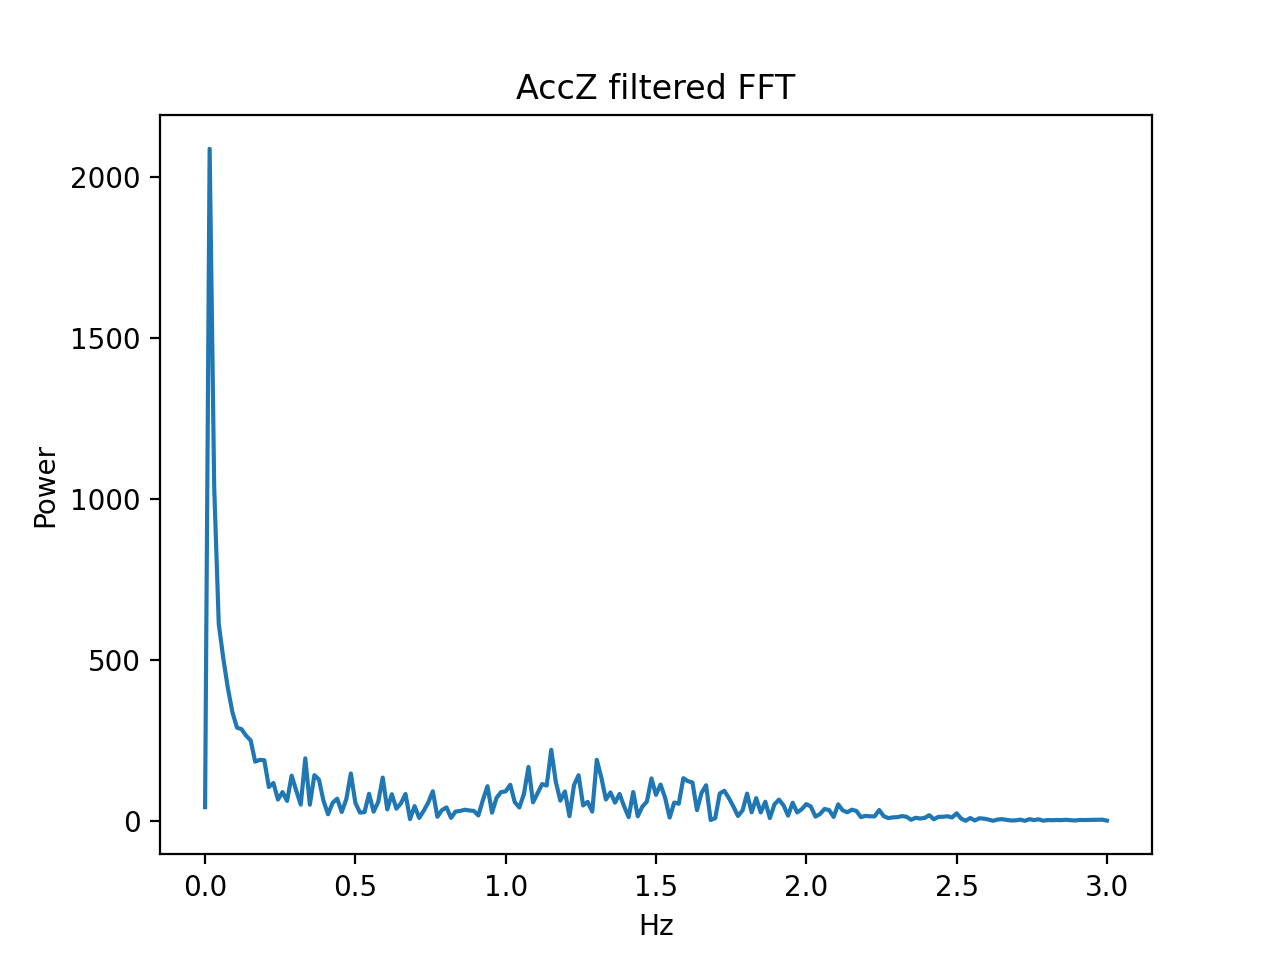

Text(0, 0.5, 'Power')

In [78]:
fft_accZ_fil=fft.fft(filtered)
accZ_freq_fil = fft.fftfreq(filtered.size, d=time_step)
power_accZ_fil = np.abs(fft_accZ_fil)

mask_fil=np.where(accZ_freq_fil>=0)

accZ_freq_fil1=accZ_freq_fil[mask_fil]
power_accZ_fil1=power_accZ_fil[mask_fil]

mask_fil1=np.where(accZ_freq_fil1<=3)

fig, ax = plt.subplots()
ax.plot(accZ_freq_fil1[mask_fil1],power_accZ_fil1[mask_fil1])
ax.set_title('AccZ filtered FFT')
ax.set_xlabel('Hz')
ax.set_ylabel('Power')